In [1]:
%matplotlib inline

# Example plot for LFPy: Mainen and Sejnowski (1996) spike waveforms
This is an example scripts using LFPy with an active cell model adapted from
Mainen and Sejnowski, Nature 1996, for the original files, see
http://senselab.med.yale.edu/modeldb/ShowModel.asp?model=2488

This scripts is set up to use the model, where the active conductances are set
in the file "active_declarations_example2.hoc", and uses the mechanisms from
the .mod-files provided here. For this example to work, run "nrnivmodl" in
this folder to compile these mechanisms
(i.e. /$PATHTONEURON/nrn/x86_64/bin/nrnivmodl).

A single excitatory synapse drive the neuron into producing a single action-
potential, and the local field potential are calculated on a dense 2D-grid
on around the soma.


Copyright (C) 2017 Computational Neuroscience Group, NMBU.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

In [2]:
import os
from os.path import join
import sys
from urllib.request import urlopen
import zipfile
import ssl
from warnings import warn
import LFPy
import neuron
import numpy as np
import matplotlib.pyplot as plt

## Fetch Mainen&Sejnowski 1996 model files:

In [3]:
if not os.path.isfile(join('cells', 'cells', 'j4a.hoc')):
    # get the model files:
    u = urlopen('http://senselab.med.yale.edu/ModelDB/eavBinDown.asp?o=2488&a=23&mime=application/zip',
                context=ssl._create_unverified_context())
    localFile = open('patdemo.zip', 'wb')
    localFile.write(u.read())
    localFile.close()
    #unzip:
    myzip = zipfile.ZipFile('patdemo.zip', 'r')
    myzip.extractall('.')
    myzip.close()

# compile mod files every time, because of incompatibility with Hay2011 files:
if "win32" in sys.platform:
    pth = "cells"
    warn("no autompile of NMODL (.mod) files on Windows. " 
         + "Run mknrndll from NEURON bash in the folder cells and rerun example script")
    if not pth in neuron.nrn_dll_loaded:
        neuron.h.nrn_load_dll(pth+"/nrnmech.dll")
    neuron.nrn_dll_loaded.append(pth)
else:
    os.system('''
              cd cells
              nrnivmodl
              ''')
    neuron.load_mechanisms('cells')

/usr/bin/xcrun
/Users/espenhagen/Repositories/LFPy/examples/cells
-n Mod files:
-n  "./ca.mod"
-n  "./cad.mod"
-n  "./kca.mod"
-n  "./km.mod"
-n  "./kv.mod"
-n  "./na.mod"


COBJS=''
 -> Compiling mod_func.c
arm64-apple-darwin20.0.0-clang -g  -O2   -I.   -I/Applications/NEURON/include  -I/opt/homebrew/Cellar/open-mpi/4.1.1_2/include -fPIC -c mod_func.c -o mod_func.o
 => LINKING shared library ./libnrnmech.dylib
arm64-apple-darwin20.0.0-clang++ -g  -O2  -std=c++11 -dynamiclib -Wl,-headerpad_max_install_names -undefined dynamic_lookup -fPIC  -I /Applications/NEURON/include -o ./libnrnmech.dylib -Wl,-install_name,@rpath/libnrnmech.dylib \
	  ./mod_func.o ./ca.o ./cad.o ./kca.o ./km.o ./kv.o ./na.o  -L/Applications/NEURON/lib -lnrniv -Wl,-rpath,/Applications/NEURON/lib    -lreadline
rm -f ./.libs/libnrnmech.so ; mkdir -p ./.libs ; cp ./libnrnmech.dylib ./.libs/libnrnmech.so
Successfully created arm64/special


## Simulation parameters:
Define parameters, using dictionaries. It is possible to set a few more parameters for each class or functions, but we chose to show only the most important ones here.

In [4]:
# define cell parameters used as input to cell-class
cellParameters = {
    'morphology' : 'morphologies/L5_Mainen96_wAxon_LFPy.hoc',
    'cm' : 1.0,                 # membrane capacitance
    'Ra' : 150,                 # axial resistance
    'v_init' : -65,             # initial crossmembrane potential
    'passive' : True,           # turn on passive mechanism
    'passive_parameters' : {'g_pas' : 1./30000, 'e_pas' : -65}, # passive params
    'nsegs_method' : 'lambda_f',# method for setting number of segments,
    'lambda_f' : 500,           # segments are isopotential at this frequency
    'dt' : 2**-5,               # dt of LFP and NEURON simulation.
    'tstart' : -10,             # start time, recorders start at t=0
    'tstop' : 10,               # stop time of simulation
    'custom_code'  : ['active_declarations_example2.hoc'], # will run this file
}

In [5]:
# Synaptic parameters, corresponding to a NetCon synapse built into NEURON
synapseParameters = {
    'idx' : 0,               # insert synapse on index "0", the soma
    'e' : 0.,                # reversal potential of synapse
    'syntype' : 'Exp2Syn',   # conductance based double-exponential synapse
    'tau1' : 1.0,            # Time constant, rise
    'tau2' : 1.0,            # Time constant, decay
    'weight' : 0.03,         # Synaptic weight
    'record_current' : True, # Will enable synapse current recording
}

In [6]:
# Generate the grid in xz-plane over which we calculate local field potentials
X, Z = np.mgrid[-5:6, -5:6] * 10
Y = np.zeros(X.shape)

# define parameters for extracellular recording electrode, using optional method
electrodeParameters = {
    'sigma' : 0.3,              # extracellular conductivity
    'x' : X.flatten(),        # x,y,z-coordinates of contact points
    'y' : Y.flatten(),
    'z' : Z.flatten(),
    'method' : 'root_as_point',  #treat soma segment as sphere source
}

## Main simulation procedure, setting up extracellular electrode, cell, synapse:

In [7]:
# Initialize cell instance, using the LFPy.Cell class
cell = LFPy.Cell(**cellParameters)
# set the position of midpoint in soma to Origo (not needed, this is the default)
cell.set_pos(x=0, y=0, z=0)
# align apical dendrite to z-axis and rotate the morphology 90 degrees around z-axis
cell.set_rotation(x=4.98919, y=-4.33261, z=np.pi/2)

adding spines
active ion-channels inserted.


In [8]:
# create extracellular electrode object
electrode = LFPy.RecExtElectrode(cell=cell, **electrodeParameters)

# attach synapse with parameters and set spike time
synapse = LFPy.Synapse(cell, **synapseParameters)
synapse.set_spike_times(np.array([1]))

# perform NEURON simulation, results saved as attributes in the cell instance
cell.simulate(probes=[electrode])

Adjusting r-distance to root segments
Adjusting r-distance to root segments
Adjusting r-distance to root segments
Adjusting r-distance to root segments
Adjusting r-distance to root segments


## Plotting of simulation results:

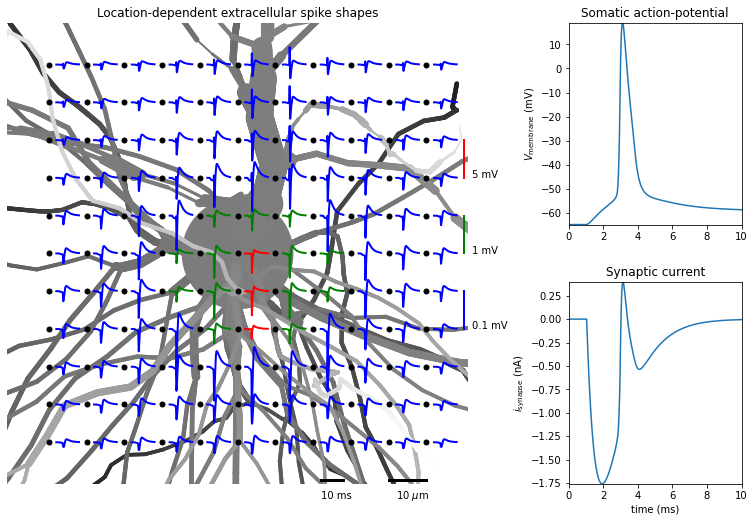

In [9]:
from example_suppl import plot_ex2
fig = plot_ex2(cell, electrode)
# Optional: saving the figure
# fig.savefig('LFPy-example-06.pdf', dpi=300)